In [129]:
%matplotlib inline


# 07-9 "Lag features" and XGBoost

Idea: Add previous n rows of input data as features to each row, add also previous n sets of labels as features.

This notebook is intended for fitting regression models to data exported from notebook `06_Merge_and_clean_data.ipynb`

In [130]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Maria Telenczuk <https://github.com/maikia>
#         Katrina Ni <https://github.com/nilichen>
#
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import os
#import math
from math import sqrt

#import sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

#from scipy.stats import uniform, randint
import pandas as pd
import seaborn as sns

pd.set_option('display.max_columns', None)

In [131]:
path = "../../../../DATA/datavar_ragasco/Data 2021/"

Load data and add batch and count columns

In [132]:
df_X = pd.read_pickle(path + 'df_X_x1.pkl') #Take complete dataset from 2021
df_batches = pd.DataFrame()
df_batches['timediff'] = df_X['Dato'].diff(-1) #Calculate time difference between liners
def get_hours(timedelta):
    seconds = timedelta.total_seconds()
    if seconds==0:
        return 1/3600 #convert zero to small positive value for log-plot
    else:
        return seconds/3600
df_batches['timediff'] = df_batches['timediff'].apply(get_hours) #Convert time difference to hours

hours_for_batch_split = 30

df_batches['batch'] = (df_batches['timediff']>hours_for_batch_split).cumsum() #Create batch counter
df_X.dropna(inplace=True)
# Dropping 'Dato' now that batches are detected. Also dropping two columns without variation (zero std):
df_X.drop(columns=['Dato', 'Blowing_TotalTime', 'Extrusion_ProfileCycleTime'], inplace=True)
df_batches = df_batches.loc[df_X.index] # Keep only same rows as in df_X

df_batches['count'] = df_batches.groupby(['batch']).cumcount()+1

df_X.shape

(1238, 100)

In [133]:
ref = df_X.index
print((ref == df_X.index).all())
print((ref == df_batches.index).all())

True
True


Remove batches with less than 10 (measured) liners.

In [134]:
batch_counts = []
deleted = False
for batch in df_batches['batch'].unique():
    idx = df_batches.loc[df_batches['batch']==batch].index
    batch_counts.append(len(idx))
    if len(idx)<10:
        print('batch', batch, 'has less than 10')
        df_X.drop(index=idx, inplace=True)
        deleted = True
print(batch_counts)
print('Batches deleted:', deleted)

[56, 93, 63, 14, 70, 60, 45, 52, 141, 104, 45, 60, 24, 156, 179, 76]
Batches deleted: False


In [135]:
ref = df_X.index
print((ref == df_X.index).all())
print((ref == df_batches.index).all())

True
True


### Standardize, remove outliers and do PCA on X

In [136]:
df_X_norm = (df_X - df_X.mean())/df_X.std()
n_pca = 50
X_pca = PCA(n_components = n_pca).fit(df_X_norm).transform(df_X_norm)
df_X_pca = pd.DataFrame(X_pca, index=df_X_norm.index, columns=['pca'+str(i) for i in range(1, n_pca+1)])

df_y = pd.read_pickle(path + 'df_y_x1.pkl')
df_y.drop(columns=['Vekt'], inplace=True)
df_y = df_y.loc[df_X.index] # Keep only same rows as in df_X
df_y_norm = (df_y - df_y.mean())/df_y.std() # Normalize y
df_y_norm.columns = ['y'+str(i) for i in range(1, df_y_norm.shape[1]+1)] # Set anonymous column names

# Define a output-set without correlations - PCA. Makes single-output regression legitimate. Transformation can naturally be reversed.
y_PCA_model = PCA(n_components = df_y.shape[1]).fit(df_y_norm)
y_pca = y_PCA_model.transform(df_y_norm)
df_y_pca = pd.DataFrame(y_pca, index=df_X_norm.index, columns=['y_pca'+str(i) for i in range(1, df_y.shape[1]+1)])
df_y_ps = (df_y_pca - df_y_pca.mean())/df_y_pca.std() # Normalize again

pd.DataFrame([df_y.columns, df_y_norm.columns], index=['name', 'numbered labels']).T

,name,numbered labels
0,Diameter,y1
1,HøydeA,y2
2,HøydeB,y3
3,HøydeC,y4
4,Veggtykkelse sveiseflate,y5
5,Veggtykkelse minimum,y6


Detect outliers more than 4 stdevs from mean

In [137]:
n_std = 4
m1 = (df_y_ps > n_std).any(1) 
m2 = (df_y_ps < -n_std).any(1)

df_outliers = df_y_ps.loc[m1|m2]
row_absmax = df_outliers.abs().max(axis=1)
df_outliers['worst'] = row_absmax * (-1) ** df_outliers.ne(row_absmax, axis=0).all(axis=1)
df_outliers
#print(f'{len(df_outliers)} outliers found (where one or more values are more than {n_std} stdevs from mean)')

C:\Users\christiano\AppData\Local\Temp\ipykernel_27316\2513209463.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outliers['worst'] = row_absmax * (-1) ** df_outliers.ne(row_absmax, axis=0).all(axis=1)


,y_pca1,y_pca2,y_pca3,y_pca4,y_pca5,y_pca6,worst
1,-0.124777,0.206289,-0.430670,0.209762,-1.027395,-15.704627,-15.704627
165,-0.563425,-0.046520,4.332136,-0.385984,-2.035996,0.157659,4.332136
180,-0.012420,-1.081105,4.758342,0.070990,-3.234176,0.224979,4.758342
475,-0.303318,0.836290,-0.167721,0.304843,1.851443,15.692809,15.692809
577,-0.369186,0.725909,3.051871,0.779790,-1.076089,-15.628233,-15.628233
750,-0.036901,0.449164,0.093385,-1.095275,-0.125123,-15.755758,-15.755758
802,-0.078497,1.297045,1.373292,-2.114874,-1.433835,15.775743,15.775743
813,-0.245035,0.138361,4.540505,-2.574933,-1.248082,0.085257,4.540505
1161,33.790884,7.606270,2.245227,1.848341,1.723820,-0.099041,33.790884


Remove outliers

In [138]:
drop_idx = df_outliers.index
df_X_pca.drop(index=drop_idx, inplace=True)
X_pca = df_X_pca.to_numpy()
print(df_X_pca.shape)

df_batches.drop(index=drop_idx, inplace=True)

df_y_ps.drop(index=drop_idx, inplace=True)
y_ps = df_y_ps.to_numpy()
print(df_y_ps.shape)



(1229, 50)
(1229, 6)


In [139]:
ref = df_X_pca.index
print((ref == df_y_ps.index).all())
print((ref == df_batches.index).all())

True
True


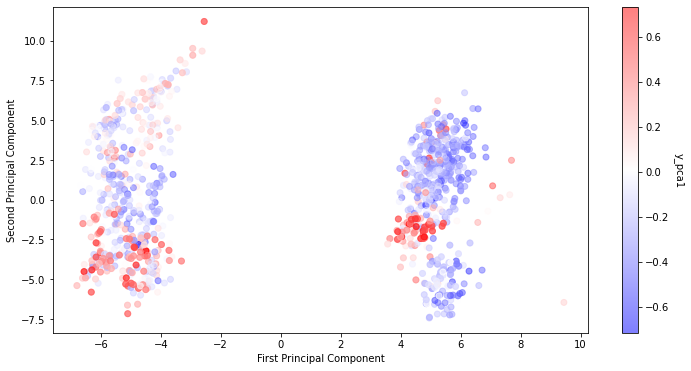

In [145]:
plt.figure(figsize =(12, 6))
colordata = 'y_pca1'
plt.scatter(df_X_pca['pca1'], df_X_pca['pca2'], c=df_y_ps[colordata], cmap ='bwr', alpha=0.5)

#c=df_batches['batch'], cmap ='tab20b'

# labeling x and y axes
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
cbar = plt.colorbar()
cbar.set_label(colordata, rotation=270)
cbar.ax.get_yaxis().labelpad = 15


### Test k-NN regression for 2021 dataset

#### First with shuffled data

In [146]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
x_pca_scaled = scaler.fit_transform(X_pca)

X_train , X_test, y_train, y_test = train_test_split(x_pca_scaled, y_ps, test_size = 0.3)

Best k: 7 (0.628)


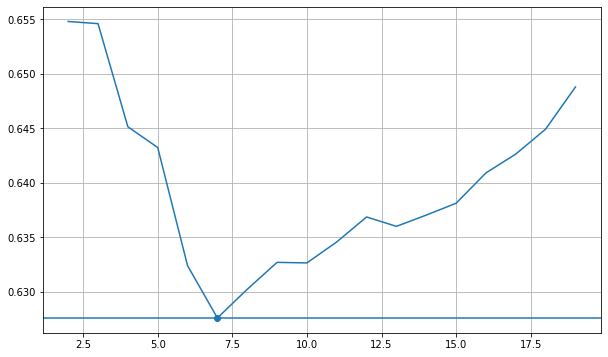

In [147]:
from sklearn import neighbors
rmse_val = [] #to store rmse values for different k
k_min, k_max = 2, 20
for k in range(k_min, k_max):
    model = neighbors.KNeighborsRegressor(n_neighbors = k)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
k_opt_idx = np.argmin(rmse_val)
k_opt = k_opt_idx + k_min
print('Best k:', k_opt, f'({rmse_val[k_opt_idx]:0.3f})')
plt.plot(np.arange(k_min,k_max), rmse_val)
plt.axhline(rmse_val[k_opt_idx])
plt.scatter(k_opt, rmse_val[k_opt_idx])
plt.grid()
plt.gcf().set_size_inches(10,6)

In [149]:
model = neighbors.KNeighborsRegressor(n_neighbors = k_opt)
model.fit(X_train, y_train)  #fit the model
pred=model.predict(X_test) #make prediction on test set

for label in range(y_test.shape[1]):
    print(df_y_ps.columns.values[label], 'r2 =', r2_score(y_test[:,label], pred[:,label]))

y_pca1 r2 = 0.7016083960031354
y_pca2 r2 = 0.5766891350951548
y_pca3 r2 = 0.11045750439680624
y_pca4 r2 = 0.4229306599450434
y_pca5 r2 = 0.3766494267531644
y_pca6 r2 = 0.24409894898932993


#### Now we test on chronological data - _still doesn't work_

In [150]:
split_idx = int(len(df_X)*0.7)
X_train , X_test = x_pca_scaled[:split_idx, :], x_pca_scaled[split_idx:, :]
y_train, y_test = y_ps[:split_idx, :], y_ps[split_idx:, :]
print(np.shape(X_train), np.shape(X_test))
print(np.shape(y_train), np.shape(y_test))

(866, 50) (363, 50)
(866, 6) (363, 6)


Best k: 143 (0.777)


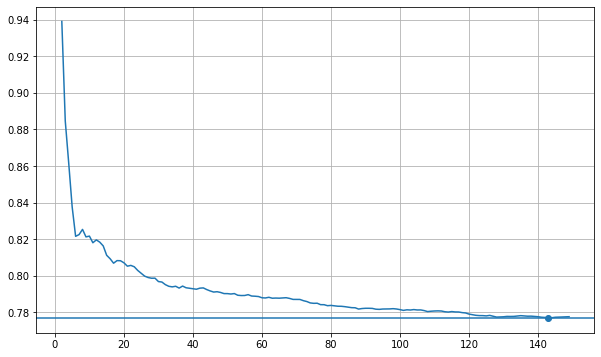

In [151]:
from sklearn import neighbors
rmse_val = [] #to store rmse values for different k
k_min, k_max = 2, 150
for k in range(k_min, k_max):
    model = neighbors.KNeighborsRegressor(n_neighbors = k)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
k_opt_idx = np.argmin(rmse_val)
k_opt = k_opt_idx + k_min
print('Best k:', k_opt, f'({rmse_val[k_opt_idx]:0.3f})')
plt.plot(np.arange(k_min,k_max), rmse_val)
plt.axhline(rmse_val[k_opt_idx])
plt.scatter(k_opt, rmse_val[k_opt_idx])
plt.grid()
plt.gcf().set_size_inches(10,6)

In [152]:
model = neighbors.KNeighborsRegressor(n_neighbors = k_opt)
model.fit(X_train, y_train)  #fit the model
pred=model.predict(X_test) #make prediction on test set

for label in range(y_test.shape[1]):
    print(df_y_ps.columns.values[label], 'r2 =', r2_score(y_test[:,label], pred[:,label]))

y_pca1 r2 = -1.2414031578048683
y_pca2 r2 = -0.12704182723557222
y_pca3 r2 = -0.1236704845698442
y_pca4 r2 = 0.08048510265053965
y_pca5 r2 = -0.03930526751927088
y_pca6 r2 = -0.017258646123872623


### Add lag features from both input and output 

First scale X_pca (again)

In [153]:
df_X_ps = (df_X_pca - df_X_pca.mean())/df_X_pca.std()

`Note:` Expect that lag features between batches will create confusion. Therefore, after adding lag features from `n` previous parts, the `n` first rows of data in each batch should then be removed from the dataset since they will contain lag features from the previous batch.

And how many lag features of input and output should we add? In theory they don't have to be equal and could be seen as data-centric hyper-parameters.

In [154]:
n_lag_input = 5
n_lag_output = 5

df_list = [df_X_ps]
X_cols = df_X_ps.columns
y_cols = df_y_ps.columns

for i in range(1, n_lag_input+1):
    temp_X = df_X_ps.shift(i)
    temp_X.columns = [col+'-'+str(i) for col in X_cols]
    df_list.append(temp_X)

for i in range(1, n_lag_output+1):
    temp_y = df_y_ps.shift(i)
    temp_y.columns = [col+'-'+str(i) for col in y_cols]
    df_list.append(temp_y)

df_X_lagged = pd.concat(df_list, axis=1)
#df_X_lagged.dropna(inplace=True)
print(df_X_lagged.shape)

(1229, 330)


Now we need to remove the first ``max(n_lag_input, n_lag_output)`` parts in each batch to avoid batches mixing due to lag features

In [156]:
thresh = np.max([n_lag_input, n_lag_output])
keep_idx = df_batches.loc[df_batches['count']>thresh].index
df_X_lagged = df_X_lagged.loc[keep_idx]
df_batches = df_batches.loc[keep_idx]

#df_X_lagged.dropna(inplace=True)
print(df_X_lagged.shape)

df_y_ps = df_y_ps.loc[keep_idx]
y_ps = df_y_ps.to_numpy()
df_y = df_y.loc[keep_idx]
print(df_y_ps.shape)

(1150, 330)
(1150, 6)


In [157]:
ref = df_X_lagged.index
print((ref == df_y_ps.index).all())
print((ref == df_batches.index).all())

True
True


In [159]:
df_X_lagged.to_pickle(path + 'df_X_lagged_5_5.pkl')
df_y_ps.to_pickle(path + 'df_y_ps.pkl')


In [160]:
df_y_ps

,y_pca1,y_pca2,y_pca3,y_pca4,y_pca5,y_pca6
5,-0.193811,1.418957,-0.756709,0.378870,-2.401862,0.074095
6,-0.349229,1.537563,-0.534553,0.873503,-2.195276,0.081295
7,-0.255262,0.075021,0.033883,0.291575,0.437571,0.004722
8,-0.166047,0.583515,-0.583939,0.138067,-1.491023,0.049453
9,-0.224227,1.661989,-1.357358,-1.447774,-2.456039,0.022485
...,...,...,...,...,...,...
1235,0.182798,0.318821,-0.398991,-0.703208,0.002256,-0.013676
1236,0.361537,-0.311175,-0.586437,-0.975360,-0.273339,-0.008206
1237,0.361537,-0.311175,-0.586437,-0.975360,-0.273339,-0.008206
1238,0.473674,-1.077154,0.216932,-0.622848,-0.107414,0.016404


Check if lagged outputs correlate with outputs

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

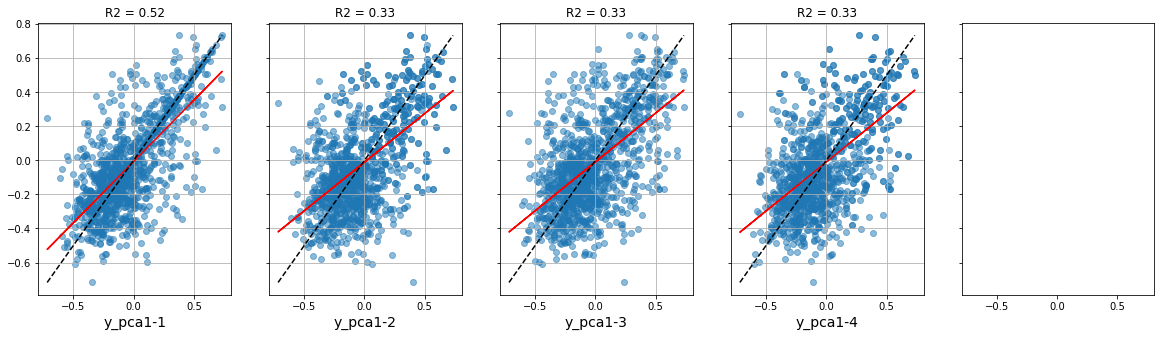

In [162]:
from sklearn.linear_model import LinearRegression
fig, axs = plt.subplots(1, n_lag_output, figsize=(20, 5), sharex=True, sharey=True)
label = 'y_pca1'

for i in range(1, n_lag_output+1):
    lag_label = label+'-'+str(i)
    x = df_X_lagged[lag_label].values.reshape(-1,1)
    y = df_y_ps[label].values
    y_lin = LinearRegression().fit(x,y).predict(x)
    axs[i-1].scatter(df_y_ps[label], df_X_lagged[label+'-'+str(i)], alpha=0.5)
    axs[i-1].plot(x, y_lin, color='r')
    axs[i-1].plot([np.min(x), np.max(x)], [np.min(x), np.max(x)], color='black', linestyle='dashed')


    r2_lag = r2_score(y, y_lin)
    axs[i-1].set_title(f'R2 = {r2_lag:0.2f}')
    axs[i-1].set_xlabel(lag_label, fontsize=14)
    axs[i-1].grid()
_ = axs[0].set_ylabel(label, rotation=0, fontsize=14)
plt.tight_layout()

### What happens if we do another PCA?

Result: Theres not enough redundant information to reduce the number of variables significantly.

Text(0.5, 0, 'Number of principal components')

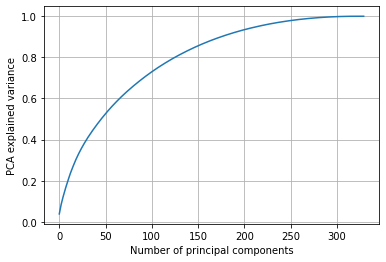

In [101]:
n_pca = 330
X_lag_PCAmodel = PCA(n_components = n_pca).fit(df_X_lagged)
X_lag_pca = X_lag_PCAmodel.transform(df_X_lagged)
df_X_lag_pca = pd.DataFrame(X_lag_pca, columns=['pca'+str(i) for i in range(1, n_pca+1)])

s_pca50_ev = pd.Series(X_lag_PCAmodel.explained_variance_ratio_).cumsum()
s_pca50_ev.plot()
plt.grid()
plt.ylabel('PCA explained variance')
plt.xlabel('Number of principal components')

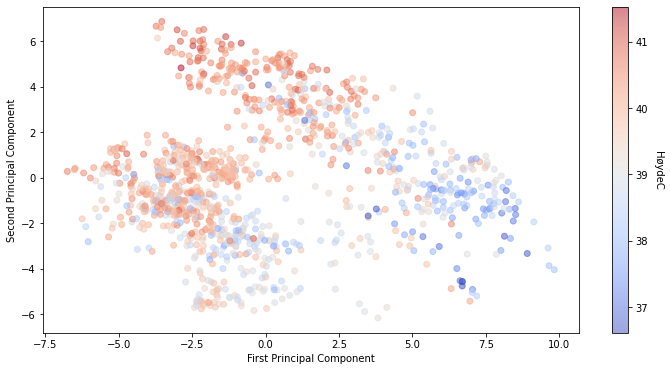

In [102]:
plt.figure(figsize =(12, 6))
colordata = 'HøydeC'
plt.scatter(df_X_lag_pca['pca1'], df_X_lag_pca['pca2'], c=df_y[colordata], cmap ='coolwarm', alpha=0.5)
#c=df_batches['batch'], cmap ='tab20b'

# labeling x and y axes
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
cbar = plt.colorbar()
cbar.set_label(colordata, rotation=270)
cbar.ax.get_yaxis().labelpad = 15

#### Try k-NN regression again
Shuffled data first

In [103]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_lag_pca_scaled = scaler.fit_transform(X_lag_pca)

X_train , X_test, y_train, y_test = train_test_split(X_lag_pca_scaled, y_norm, test_size = 0.3)

Best k: 6 (0.980)


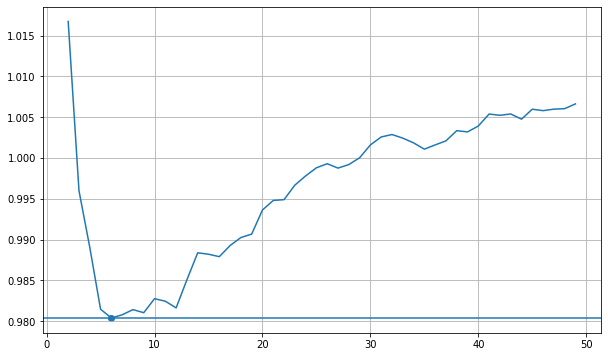

In [105]:
from sklearn import neighbors
rmse_val = [] #to store rmse values for different k
k_min, k_max = 2, 50
for k in range(k_min, k_max):
    model = neighbors.KNeighborsRegressor(n_neighbors = k)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
k_opt_idx = np.argmin(rmse_val)
k_opt = k_opt_idx + k_min
print('Best k:', k_opt, f'({rmse_val[k_opt_idx]:0.3f})')
plt.plot(np.arange(k_min,k_max), rmse_val)
plt.axhline(rmse_val[k_opt_idx])
plt.scatter(k_opt, rmse_val[k_opt_idx])
plt.grid()
plt.gcf().set_size_inches(10,6)

In [106]:
model = neighbors.KNeighborsRegressor(n_neighbors = k_opt)
model.fit(X_train, y_train)  #fit the model
pred=model.predict(X_test) #make prediction on test set

for label in range(y_test.shape[1]):
    print(df_y.columns.values[label], 'r2 =', r2_score(y_test[:,label], pred[:,label]))

Diameter r2 = 0.02544822160814386
HøydeA r2 = 0.2323097721620403
HøydeB r2 = -0.2801770184096617
HøydeC r2 = 0.12284837026283657
Veggtykkelse sveiseflate r2 = 0.1491029163646267
Veggtykkelse minimum r2 = 0.09149173325235649


#### Now we test on chronological data - _still doesn't work_

In [107]:
split_idx = int(len(X_lag_pca_scaled)*0.7)
X_train , X_test = X_lag_pca_scaled[:split_idx, :], X_lag_pca_scaled[split_idx:, :]
y_train, y_test = y_norm[:split_idx, :], y_norm[split_idx:, :]
print(np.shape(X_train), np.shape(X_test))
print(np.shape(y_train), np.shape(y_test))

(804, 330) (345, 330)
(804, 6) (345, 6)


Best k: 15 (1.064)


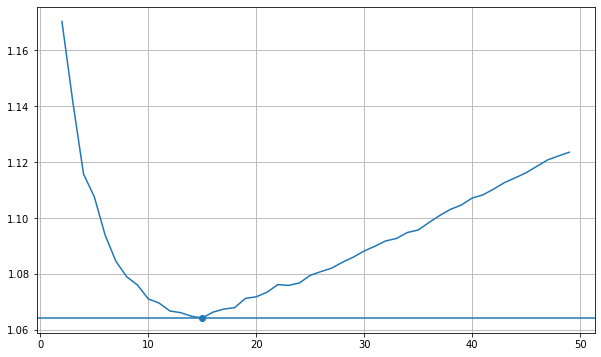

In [110]:
from sklearn import neighbors
rmse_val = [] #to store rmse values for different k
k_min, k_max = 2, 50
for k in range(k_min, k_max):
    model = neighbors.KNeighborsRegressor(n_neighbors = k)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
k_opt_idx = np.argmin(rmse_val)
k_opt = k_opt_idx + k_min
print('Best k:', k_opt, f'({rmse_val[k_opt_idx]:0.3f})')
plt.plot(np.arange(k_min,k_max), rmse_val)
plt.axhline(rmse_val[k_opt_idx])
plt.scatter(k_opt, rmse_val[k_opt_idx])
plt.grid()
plt.gcf().set_size_inches(10,6)

In [109]:
model = neighbors.KNeighborsRegressor(n_neighbors = k_opt)
model.fit(X_train, y_train)  #fit the model
pred=model.predict(X_test) #make prediction on test set
print('Using k =', k_opt, '\n')

for label in range(y_test.shape[1]):
    print(df_y.columns.values[label], 'r2 =', r2_score(y_test[:,label], pred[:,label]))

Using k = 15 

Diameter r2 = -1.1514584523189577
HøydeA r2 = -0.23928098920681218
HøydeB r2 = -0.7370163901917417
HøydeC r2 = -0.01951973576081678
Veggtykkelse sveiseflate r2 = -0.8927880438787403
Veggtykkelse minimum r2 = -0.04174292948285485


## Baseline: Predict y = y_prev
What kind of R2 do we get then?

In [50]:
df_y_predict = df_y.shift(1)
df_y_predict.dropna(inplace=True)
df_y = df_y.loc[df_y_predict.index]

for label in df_y.columns:
    print(label, f'R2 = {r2_score(df_y[label], df_y_predict[label]):0.2f}')

Diameter R2 = -0.10
HøydeA R2 = 0.42
HøydeB R2 = 0.53
HøydeC R2 = 0.34
Veggtykkelse sveiseflate R2 = 0.08
Veggtykkelse minimum R2 = 0.06


`Note`: Check out standard error as supplement to R2

<AxesSubplot:xlabel='HøydeC', ylabel='Count'>

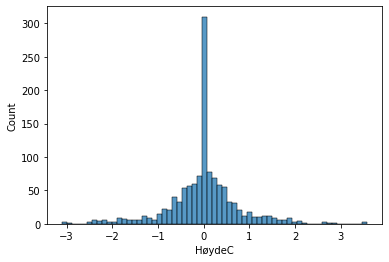

In [51]:
df_pred_err = df_y - df_y_predict
sns.histplot(df_pred_err['HøydeC'])
#plt.xlim(-1, 1)

## Test out XGBoost regression with lagged dataset

In [111]:
X_lagged = df_X_lagged.to_numpy()
y_norm = df_y_norm.to_numpy()

1) Split train, validate and test chronologinally and keep them in original order. Train on first 3 parts, validate on part 4 and test on part 5

In [30]:
split_val = int(len(X_lagged)*0.6)
split_test = int(len(X_lagged)*0.8)
X_train, X_val, X_test = X_lagged[:split_val,:], X_lagged[split_val+1:split_test,:], X_lagged[split_test+1:,:]
y_train, y_val, y_test = y_norm[:split_val,:], y_norm[split_val+1:split_test,:], y_norm[split_test+1:,:]
print('X_train:', X_train.shape, 'X_val:', X_val.shape, 'X_test:', X_test.shape)
print('y_train:', y_train.shape, 'y_val:', y_val.shape, 'y_test:', y_test.shape)
print('y_cols:', y_cols)

Note = 'Chr. train/val/test X_lagged'

X_train: (733, 330) X_val: (243, 330) X_test: (244, 330)
y_train: (733, 6) y_val: (243, 6) y_test: (244, 6)
y_cols: Index(['y1', 'y2', 'y3', 'y4', 'y5', 'y6'], dtype='object')


2) Split train, validate and test chronologinally, and shuffle _afterwards_. Train on first 3 parts, validate on part 4 and test on part 5

In [33]:
import sklearn

split_val = int(len(X_lagged)*0.6)
split_test = int(len(X_lagged)*0.8)
X_train, X_val, X_test = X_lagged[:split_val,:], X_lagged[split_val+1:split_test,:], X_lagged[split_test+1:,:]
y_train, y_val, y_test = y_norm[:split_val,:], y_norm[split_val+1:split_test,:], y_norm[split_test+1:,:]

X_train, y_train = sklearn.utils.shuffle(X_train, y_train, random_state=42)
X_val, y_val = sklearn.utils.shuffle(X_val, y_val, random_state=42)
#X_test, y_test = sklearn.utils.shuffle(X_test, y_test, random_state=42)


print('X_train:', X_train.shape, 'X_val:', X_val.shape, 'X_test:', X_test.shape)
print('y_train:', y_train.shape, 'y_val:', y_val.shape, 'y_test:', y_test.shape)
print('y_cols:', y_cols)

Note = 'Chr.+shuffle train/val/test X_lagged'

X_train: (733, 330) X_val: (243, 330) X_test: (244, 330)
y_train: (733, 6) y_val: (243, 6) y_test: (244, 6)
y_cols: Index(['y1', 'y2', 'y3', 'y4', 'y5', 'y6'], dtype='object')


3. Split randomly into train and validate (shuffle first) but take end portion as test

In [112]:
split_test = int(len(X_lagged)*0.8)
X_train, X_test = X_lagged[:split_test,:], X_lagged[split_test+1:,:]
y_train, y_test = y_norm[:split_test,:], y_norm[split_test+1:,:]

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
print('X_train:', X_train.shape, 'X_val:', X_val.shape, 'X_test:', X_test.shape)
print('y_train:', y_train.shape, 'y_val:', y_val.shape, 'y_test:', y_test.shape)
print('y_cols:', y_cols)

Note = 'Random train/val but end as test. X_lagged'

X_train: (689, 330) X_val: (230, 330) X_test: (229, 330)
y_train: (689, 6) y_val: (230, 6) y_test: (229, 6)
y_cols: Index(['y1', 'y2', 'y3', 'y4', 'y5', 'y6'], dtype='object')


4. Split randomly into train, validate and test. (Data are shuffled before the split.)

This should give the best results but is unrealistic in terms of real application

In [37]:

X_train, X_test, y_train, y_test = train_test_split(X_lagged, y_norm, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
print('X_train:', X_train.shape, 'X_val:', X_val.shape, 'X_test:', X_test.shape)
print('y_train:', y_train.shape, 'y_val:', y_val.shape, 'y_test:', y_test.shape)
print('y_cols:', y_cols)

Note = 'Random train/val/test X_lagged'

X_train: (732, 330) X_val: (245, 330) X_test: (245, 330)
y_train: (732, 6) y_val: (245, 6) y_test: (245, 6)
y_cols: Index(['y1', 'y2', 'y3', 'y4', 'y5', 'y6'], dtype='object')


### Fit regression model

NB: Update `fit_file` according to notebook name/number


Set the regression model parameters. 


In [120]:
import xgboost as xgb

params = {
    "objective": "reg:squarederror",
    "random_state": 42,
    "subsample": 0.5, # subsample ratio of columns when constructing each tree.
    'colsample_bytree': 0.5,
    #'alpha': 0.5757147587224918,
    #'lambda': 0.6751025760853637,
    #'gamma': 0.004714915573102214,
    #'learning_rate': 0.18832358744106376,
    #'max_depth': 5,
    #'n_estimators': 269
    "alpha": 0, # L1 regularization term on weights. Increasing this value will make model more conservative.
    "lambda": 1, # L2 regularization term on weights. Increasing this value will make model more conservative.
    "gamma": 0.01, # Minimum loss reduction required to make a further partition on a leaf node of the tree. Higher -> more conservative. [0,inf]
    "learning_rate": 0.04, # default 0.3 
    "max_depth": 5, # default 3
    "n_estimators": 400, # default 100
    #"verbose_eval": True# Chose wether to print output during training (1) or no printing (0)
}


##Optimal parameter set so far:
#

In [121]:
# Prepare dataframe of rmse results and parameter values, or load existing dataframe from file if `fit_file`exists

fit_file = '07-9_fitting_results.pkl' # NB: Update name according to notebook number

if os.path.exists(fit_file):
    fit_results = pd.read_pickle(fit_file)
else:
    res_cols = ['Note']
    for col in df_y_norm.columns:
        res_cols.append(col+' RMSE')
        res_cols.append(col+' R2')
    res_cols.append('R2 mean')
    for key in params.keys():
        res_cols.append(key)
    res_cols.append('Training time')
        
    fit_results = pd.DataFrame(columns=res_cols)


start_time = datetime.now()


# ----------------- Calculate root mean squared error of predictions and -------------------------
# ----------------- store results in dataframe together with parameter values used -------------------------
res_labels = ['Note']
res_values = [Note]
r2_values = []

regs = []
ests = []
for i in range(y_train.shape[1]):
    reg = xgb.XGBRegressor(**params, verbose_eval=20) 
    reg.set_params(early_stopping_rounds=20)
    reg.fit(X_train, y_train[:,i], eval_set=[(X_val, y_val[:,i])]) # Fit model for label i
    regs.append(reg)

    y_test_estimated = reg.predict(X_test) # Predict label values on test set
    ests.append(y_test_estimated)
    rmse = np.sqrt(mean_squared_error(y_test[:,i], y_test_estimated))
    res_values.append(rmse)
    label = y_cols[i]
    res_labels.append(label+' RMSE')
    
    res_labels.append(label+' R2')
    r2 = reg.score(X_test, y_test[:,i])
    res_values.append(r2)
    r2_values.append(r2)

res_labels.append('R2 mean')
res_values.append(np.mean(r2_values))

for key in params.keys():
    res_values.append(params[key])
    res_labels.append(key)

training_time = (datetime.now() - start_time).total_seconds()
res_values.append(training_time)
res_labels.append('Training time')

df_tmp = pd.DataFrame([res_values], columns=res_labels, index=[datetime.now().date()])
fit_results = fit_results.append(df_tmp)
#fit_results = fit_results.sort_values('R2', ascending=False)
fit_results.to_pickle(fit_file)
fit_results

[15:13:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[0]	validation_0-rmse:1.16382
[1]	validation_0-rmse:1.15362
[2]	validation_0-rmse:1.14039
[3]	validation_0-rmse:1.12691
[4]	validation_0-rmse:1.12139
[5]	validation_0-rmse:1.11212
[6]	validation_0-rmse:1.10380
[7]	validation_0-rmse:1.09478
[8]	validation_0-rmse:1.08605
[9]	validation_0-rmse:1.07908
[10]	validation_0-rmse:1.07212
[11]	validation_0-rmse:1.06613
[12]	validation_0-rmse:1.05905
[13]	validation_0-rmse:1.04912
[14]	validation_0-rmse:1.04391
[15]	validation_0-rmse:1.03728
[16]	validation_0-rmse:1.03064
[17]	validation_0-rmse:1.02461
[18]	validation_0-rmse:1.02318
[19]	validation_0-rmse:1.01912
[20]	validation_0-rmse:1.01286
[21]	validation_0-rmse:1.00627
[22]	validation_0-rmse:1.00520
[23]	validation_0-rmse:1.00352
[24]	validation_0-rmse:0.99719
[25]	validation_0-rmse:0.99377
[2

C:\Users\christiano\AppData\Local\Temp\ipykernel_27316\2620266533.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fit_results = fit_results.append(df_tmp)


,Note,y1 RMSE,y1 R2,y2 RMSE,y2 R2,y3 RMSE,y3 R2,y4 RMSE,y4 R2,y5 RMSE,y5 R2,y6 RMSE,y6 R2,R2 mean,objective,random_state,subsample,colsample_bytree,alpha,lambda,gamma,learning_rate,max_depth,n_estimators,Training time
2023-02-14,Random train/val but end as test. X_lagged,0.665869,0.044682,0.855291,0.258591,0.808147,-0.323777,0.720693,0.597617,0.554420,0.415423,0.707698,0.323201,0.219290,reg:squarederror,42,0.5,0.5,0,1,0.01,0.025,10,200,16.589092
2023-02-14,Random train/val but end as test. X_lagged,0.680916,0.001018,0.837414,0.289261,0.819099,-0.359900,0.723300,0.594702,0.558918,0.405898,0.718097,0.303166,0.205691,reg:squarederror,42,0.5,0.5,0,1,0.01,0.030,10,200,18.051790
2023-02-14,Random train/val but end as test. X_lagged,0.705420,-0.072176,0.859422,0.251412,0.807236,-0.320795,0.724623,0.593218,0.553726,0.416885,0.730960,0.277978,0.191087,reg:squarederror,42,0.5,0.5,0,1,0.01,0.040,10,200,22.137000
2023-02-14,Random train/val but end as test. X_lagged,0.663580,0.051237,0.815767,0.325530,0.787274,-0.256279,0.697356,0.623255,0.526927,0.471961,0.698545,0.340595,0.259383,reg:squarederror,42,0.5,0.5,0,1,0.01,0.040,5,400,22.724131


### Make time plot and compare with forecast (test set)

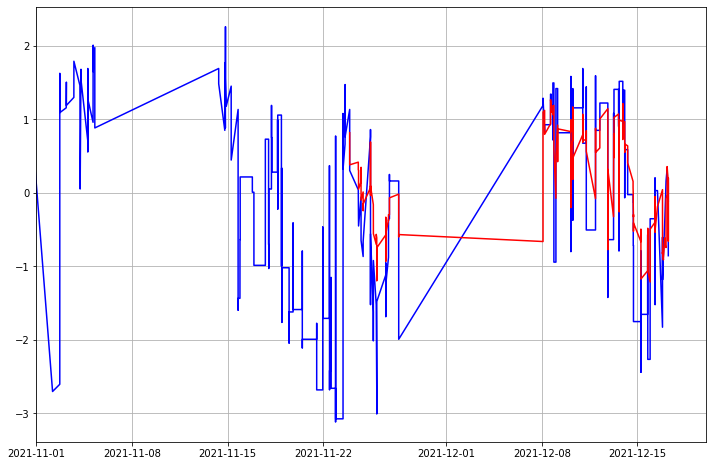

In [115]:
s_time = pd.read_pickle(path + 'df_X_x1.pkl')['Dato']
s_time = s_time.loc[df_X_lagged.index].sort_values()

split_test = int(len(X_lagged)*0.8)
plt.plot(s_time.values, y_norm[:,3], color='blue')
plt.plot(s_time.values[split_test+1:], ests[3], color='r')
plt.gcf().set_size_inches(12,8)
plt.grid()
_ = plt.xlim(np.datetime64('2021-11-01'), np.datetime64('2021-12-20'))

Save trained model?

In [ ]:
#reg.save_model('24-5L_2022_x10_102_DT.json')

#### Test out hyperparameter tuning with `sklearn_genetic`

In [180]:
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn_genetic.plots import plot_fitness_evolution, plot_search_space
from sklearn.model_selection import KFold

param_grid = {#"objective": Categorical(["reg:squarederror"]),
              #"random_state": Categorical([42]),
              #"subsample": Continuous(0.2, 0.8, distribution='uniform'), # subsample ratio of columns when constructing each tree.
              #'colsample_bytree': Continuous(0.2, 0.8, distribution='uniform'),
              "alpha": Continuous(0.5, 1.5, distribution='uniform'), # L1 regularization term on weights. Increasing this value will make model more conservative.
              "lambda": Continuous(0.5, 1.5, distribution='uniform'),
              'gamma': Continuous(0.001, 0.1, distribution='log-uniform'),
              'learning_rate': Continuous(0.02, 0.15, distribution='uniform'),
              'max_depth': Integer(5, 15), 
              'n_estimators': Integer(100, 500)}

cv = KFold(n_splits=3, shuffle=True)
clf = xgb.XGBRegressor()

evolved_estimator = GASearchCV(estimator=clf,
                               cv=cv,
                               scoring='neg_mean_squared_error',
                               population_size=10,
                               generations=10,
                               tournament_size=3,
                               elitism=True,
                               crossover_probability=0.8,
                               mutation_probability=0.1,
                               param_grid=param_grid,
                               criteria='max',
                               algorithm='eaMuPlusLambda',
                               n_jobs=1,
                               verbose=True,
                               keep_top_k=3)

#Label no. 3 is HøydeC
#Using 80% of rows as train since GASearchCV uses KFold
split_test = int(len(X_lagged)*0.8)
X_train, X_test = X_lagged[:split_test,:], X_lagged[split_test+1:,:]
y_train, y_test = y_norm[:split_test,:], y_norm[split_test+1:,:]

evolved_estimator.fit(X_train, y_train[:,3])

c:\Users\christiano\AppData\Local\Programs\Python\Python38\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\christiano\AppData\Local\Programs\Python\Python38\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	fitness  	fitness_std	fitness_max	fitness_min
0  	10    	-0.357095	0.0238466  	-0.322195  	-0.394989  
1  	18    	-0.346399	0.0134353  	-0.322195  	-0.366916  
2  	19    	-0.343973	0.00845456 	-0.337204  	-0.367761  
3  	18    	-0.337688	0.00528621 	-0.324063  	-0.343934  
4  	18    	-0.33886 	0.0130079  	-0.324063  	-0.367298  
5  	19    	-0.336745	0.0077881  	-0.324063  	-0.347191  
6  	17    	-0.336043	0.0088603  	-0.326963  	-0.354611  
7  	17    	-0.332695	0.00581758 	-0.319561  	-0.337204  
8  	19    	-0.32696 	0.0086708  	-0.311049  	-0.336929  
9  	19    	-0.322305	0.00497833 	-0.311049  	-0.329386  
10 	19    	-0.322096	0.00457792 	-0.319208  	-0.332549  


GASearchCV(crossover_probability=0.8,
           cv=KFold(n_splits=3, random_state=None, shuffle=True),
           estimator=XGBRegressor(alpha=0.5128797878130932, base_score=None,
                                  booster=None, callbacks=None,
                                  colsample_bylevel=None, colsample_bynode=None,
                                  colsample_bytree=None,
                                  early_stopping_rounds=None,
                                  enable_categorical=False, eval_metric=None,
                                  feature_types=None,
                                  gamma=0.009747...
                       'lambda': <sklearn_genetic.space.space.Continuous object at 0x0000014F41D502B0>,
                       'learning_rate': <sklearn_genetic.space.space.Continuous object at 0x0000014F41D506A0>,
                       'max_depth': <sklearn_genetic.space.space.Integer object at 0x0000014F41D50520>,
                       'n_estimators': <sklearn_genetic.space.space.Integer object at 0x0000014F41D504F0>},
           population_size=10, return_train_score=True,
           scoring='neg_mean_squared_error')

In [181]:
evolved_estimator.score(X_test, y_test[:,3])

-0.51162770909944

c:\Users\christiano\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn_genetic\plots.py:52: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(


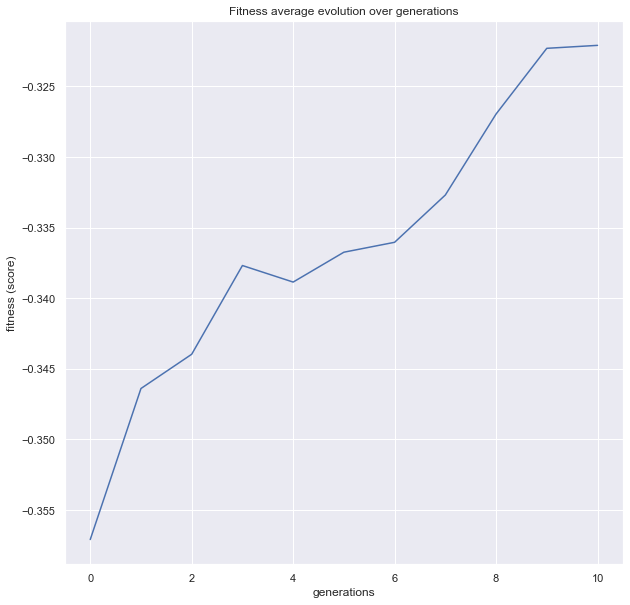

In [182]:
plot_fitness_evolution(evolved_estimator)
plt.show()

In [183]:
evolved_estimator.hof

{0: {'alpha': 0.5128797878130932,
  'lambda': 1.44124661541312,
  'gamma': 0.009747731810345833,
  'learning_rate': 0.06740203865400295,
  'max_depth': 7,
  'n_estimators': 249},
 1: {'alpha': 0.5128797878130932,
  'lambda': 1.44124661541312,
  'gamma': 0.009747731810345833,
  'learning_rate': 0.06740203865400295,
  'max_depth': 7,
  'n_estimators': 249},
 2: {'alpha': 1.3243666628582975,
  'lambda': 1.44124661541312,
  'gamma': 0.009747731810345833,
  'learning_rate': 0.06740203865400295,
  'max_depth': 7,
  'n_estimators': 249}}

In [ ]:
'alpha': 0.5757147587224918,
  'lambda': 0.6751025760853637,
  'gamma': 0.004714915573102214,
  'learning_rate': 0.18832358744106376,
  'max_depth': 5,
  'n_estimators': 269

Compare y_test values with predictions

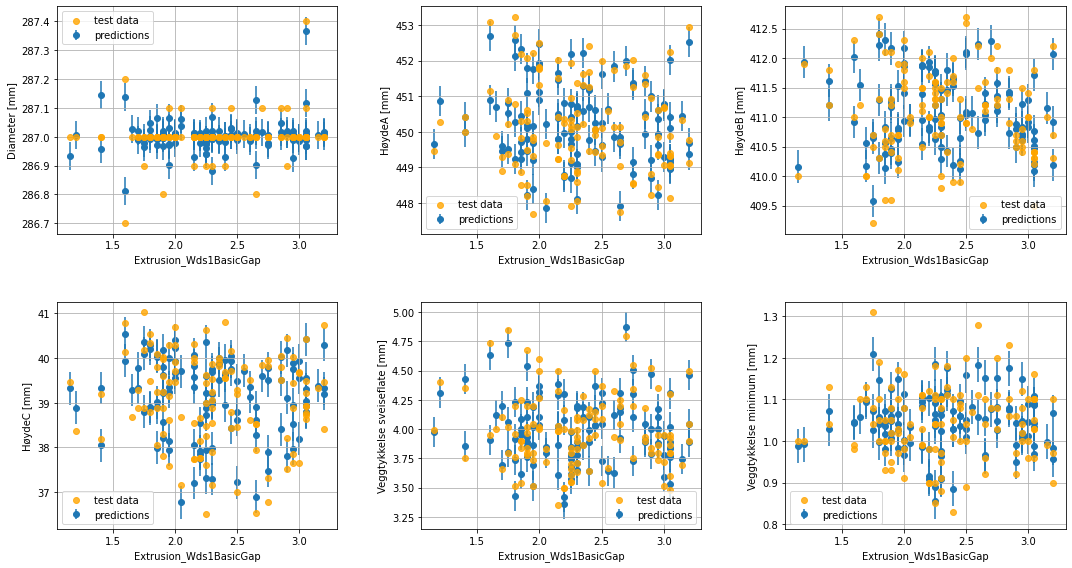

In [10]:
fig = plt.figure(figsize=(15, 4*((y.shape[1]+1)%3+1)))
feature = df_X.columns.get_loc("Extrusion_Wds1BasicGap") # feature to plot on x-axis
#feature = df_X.columns.get_loc("HeatTransfer_ModulHalf1") # feature to plot on x-axis
#Extrusion_PlcAdditionalTime

len_test = len(y_test)
len_plot = int(len_test/20)
X_not_norm_test2 = X_not_norm_test[:len_plot,:]
y_test2 = y_test[:len_plot,:]
y_test_estimated2 = y_test_estimated[:len_plot,:]


for label_no in range(y.shape[1]):
    plt.subplot((y.shape[1]+1)%3+1, math.ceil((y.shape[1]+1)/3), label_no+1)
    plt.scatter(X_not_norm_test2[:,feature], y_test2[:,label_no], color='orange', alpha=0.8, zorder=2, label='test data')
    plt.errorbar(X_not_norm_test2[:,feature], y_test_estimated2[:,label_no], rmse_values[label_no], fmt='o', alpha=1, zorder=1, label='predictions')
    #prediction_errors = y_test_estimated[:,label]-y_test[:,label]
    #plt.scatter(X_test[:,feature], prediction_errors, color='orange')
    plt.ylabel(f'{y_cols[label_no]} [mm]')
    plt.xlabel(df_X.columns[feature])
    plt.grid()
    plt.tight_layout()
    plt.legend()
    #plt.ylim(-0.1,0.1)
    
plt.subplots_adjust(wspace=0.3, hspace=0.3)
#plt.savefig('test_predict_BasicGAP_x10_XGBoost.png', dpi=300)

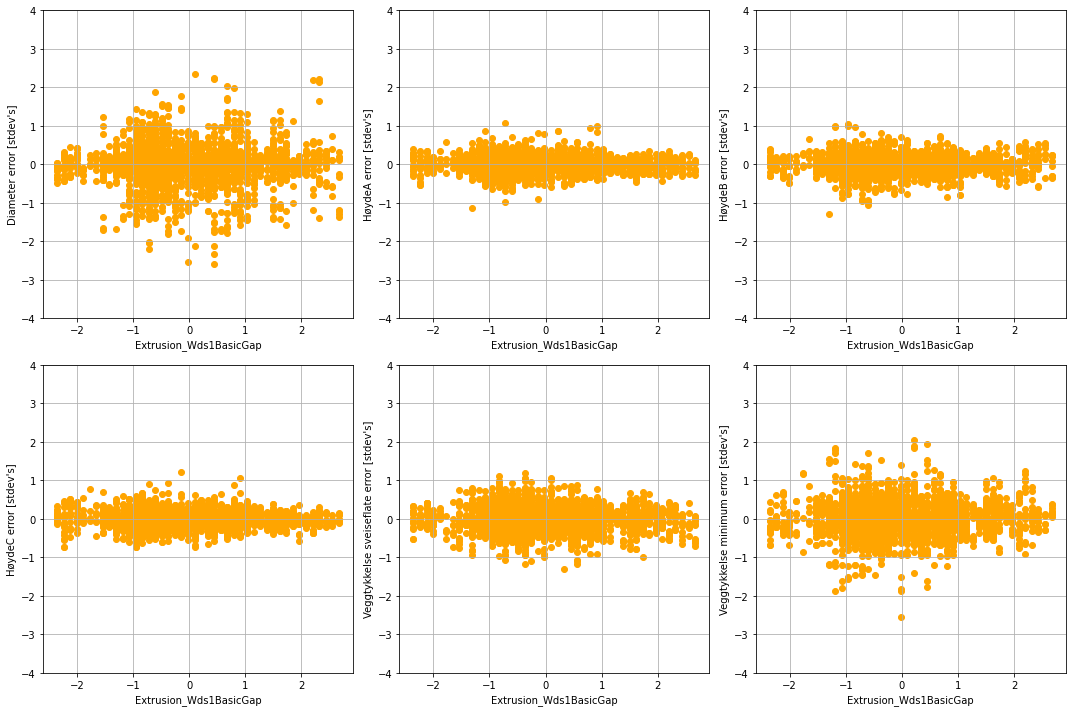

In [12]:
fig = plt.figure(figsize=(15, 5*((y.shape[1]+1)%3+1)))
feature = df_X.columns.get_loc("Extrusion_Wds1BasicGap") # feature to plot on x-axis
for label_no in range(y.shape[1]):
    plt.subplot((y.shape[1]+1)%3+1, math.ceil((y.shape[1]+1)/3), label_no+1)
    prediction_errors = y_test_estimated[:,label_no]-y_test[:,label_no]
    stdev = np.std(y_test[:,label_no])
    relative_errors = prediction_errors/stdev
    plt.scatter(X_test[:,feature], relative_errors, color='orange')
    plt.ylabel(f'{y_cols[label_no]} error [stdev\'s]')
    plt.xlabel(df_X.columns[feature])
    plt.ylim(-4,4)
    plt.grid()
    plt.tight_layout()
    #plt.ylim(-0.1,0.1)

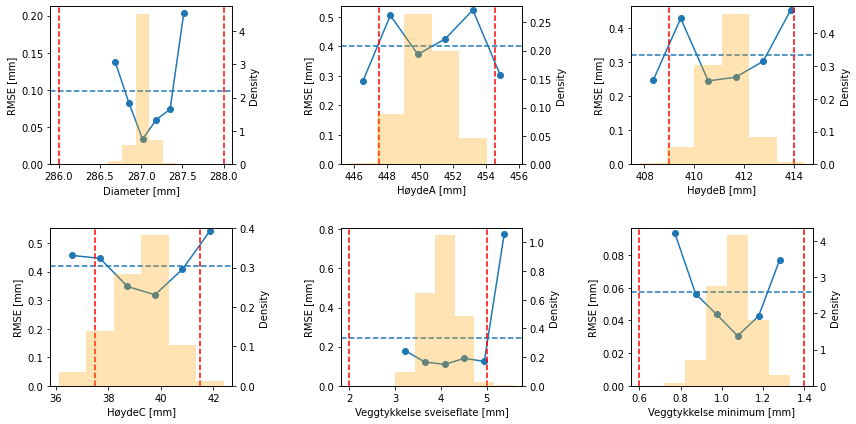

In [11]:
tolerances = pd.DataFrame([[287-1, 451-3.5, 411.5-2.5, 39.5-2, 3-1, 1-0.4],
                          [287+1, 451+3.5, 411.5+2.5, 39.5+2, 3+2, 1+0.4]],
                         columns=['Diameter','HøydeA','HøydeB','HøydeC','Veggtykkelse sveiseflate','Veggtykkelse minimum'],
                         index=['min_tol', 'max_tol'])

intervals = 6

fig = plt.figure(figsize=(12, 3*((y.shape[1]+1)%3+1)))
for label_no in range(y.shape[1]):
    plt.subplot((y.shape[1]+1)%3+1, math.ceil((y.shape[1]+1)/3), label_no+1)

    test_df = pd.DataFrame({'y_test': y_test[:,label_no],
                            'y_pred': y_test_estimated[:,label_no]})
    
    y_range = np.linspace(np.min(test_df.y_test), np.max(test_df.y_test), intervals+1)
    rmse_stats = []
    y_mids = []
    
    for i in range(len(y_range)-1):
        low = y_range[i]
        high = y_range[i+1]
        y_mids.append((low + high)/2)
        tmp_df = test_df.loc[(test_df.y_test >= low) & (test_df.y_test <= high)]
        if len(tmp_df) > 0:
            rmse_stats.append(np.sqrt(mean_squared_error(tmp_df.y_test, tmp_df.y_pred)))
        else:
            rmse_stats.append(np.nan)
    
    rmse_stats = pd.DataFrame({'y': y_mids,
                               'RMSE': rmse_stats})
    rmse_mean = rmse_stats.RMSE.mean()
    
    plt.plot(np.asarray(rmse_stats.y, float),rmse_stats.RMSE, marker='o')
    plt.axhline(rmse_mean, linestyle='--')
    plt.ylim(0,None)
    plt.ylabel(f'RMSE [mm]')
    plt.xlabel(y_cols[label_no] + ' [mm]')  
    plt.axvline(tolerances.iloc[0,label_no], color='red', linestyle ="--")
    plt.axvline(tolerances.iloc[1,label_no], color='red', linestyle ="--")
        
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    ax2.hist(test_df.y_test, bins=intervals, density=True, color='orange', alpha=0.3)
    plt.ylabel('Density')
    
    plt.tight_layout()

plt.subplots_adjust(wspace=0.6, hspace=0.4)
plt.savefig('RMSE_hist_x10_2022_XGBoost.png', dpi=300)


Calculate frequency of "correct" prediction, i.e. if prediction is inside some give range. 

For instance: Inside +/-0.5 standard deviations of the true label values in the test set.

In [12]:
threshold = 0.5
frame = []

print(f'Predictions inside +/- {threshold:0.1f} x stdev:')

for label_no in range(len(y_cols)):
    vals = []
    stdev = np.std(y_test[:,label_no])
    vals.append(stdev)
    limit = threshold * stdev
    vals.append(limit)
    diffs = y_test_estimated[:,label_no]-y_test[:,label_no]
    inside = ((diffs < limit) & (diffs > -limit)).sum()*100/len(diffs)
    vals.append(inside)
    frame.append(vals)

cols = ['σ in test set [mm]', f'+/- lim ({threshold}σ) [mm]', 'predictions inside lim[%]']
df_lim = pd.DataFrame(frame, columns=cols, index=y_cols)
df_lim['R^2'] = r2_per_label
df_lim['RMSE [mm]'] = rmse_values
df_lim.loc['Average'] = df_lim.mean()
df_lim.iloc[-1,[0,1,-1]] = " "
df_lim

Predictions inside +/- 0.5 x stdev:


,σ in test set [mm],+/- lim (0.5σ) [mm],predictions inside lim[%],R^2,RMSE [mm]
Diameter,0.090753,0.045377,79.765396,0.716711,0.048303
HøydeA,1.307587,0.653793,88.730624,0.895121,0.423462
HøydeB,0.783491,0.391745,86.635945,0.878656,0.272925
HøydeC,1.009435,0.504718,83.996649,0.868090,0.366621
Veggtykkelse sveiseflate,0.342654,0.171327,85.127775,0.858995,0.128669
Veggtykkelse minimum,0.09261,0.046305,76.413909,0.795962,0.041833
Average,,,83.445050,0.835589,


In [13]:
threshold = 0.5
frame = []
limits = [0.19,
          0.51,
          0.38,
          0.39,
          0.18,
          0.085
          ]


for label_no in range(len(y_cols)):
    vals = []
    stdev = np.std(y_test[:,label_no])
    vals.append(stdev)
    
    # Tar +/- grense fra forhåndsdefinert liste
    limit = limits[label_no]
    vals.append('+/-'+ str(limit))
    
    diffs = y_test_estimated[:,label_no]-y_test[:,label_no]
    inside = ((diffs < limit) & (diffs > -limit)).sum()*100/len(diffs)
    vals.append(inside)
    frame.append(vals)

cols = ['σ in test set [mm]', f'95% conf. interval [mm]', 'predictions inside c.i. [%]']
df_lim = pd.DataFrame(frame, columns=cols, index=y_cols)
df_lim['R^2'] = r2_per_label
df_lim['RMSE [mm]'] = rmse_values
df_lim.loc['Average'] = df_lim.mean()
df_lim.iloc[-1,[0,1,-1]] = " "
df_lim

C:\Users\christiano\AppData\Local\Temp\ipykernel_11324\1695602177.py:30: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_lim.loc['Average'] = df_lim.mean()


,σ in test set [mm],95% conf. interval [mm],predictions inside c.i. [%],R^2,RMSE [mm]
Diameter,0.090753,+/-0.19,99.078341,0.716711,0.048303
HøydeA,1.307587,+/-0.51,80.142438,0.895121,0.423462
HøydeB,0.783491,+/-0.38,85.672392,0.878656,0.272925
HøydeC,1.009435,+/-0.39,74.905739,0.868090,0.366621
Veggtykkelse sveiseflate,0.342654,+/-0.18,86.803519,0.858995,0.128669
Veggtykkelse minimum,0.09261,+/-0.085,95.266024,0.795962,0.041833
Average,,,86.978076,0.835589,


In [14]:
threshold = 0.5
frame = []
limits = [0.24,
          0.65,
          0.44,
          0.48,
          0.28,
          0.14
          ]

for label_no in range(len(y_cols)):
    vals = []
    stdev = np.std(y_test[:,label_no])
    vals.append(stdev)
    
    # Tar +/- grense fra forhåndsdefinert liste
    limit = limits[label_no]
    vals.append('+/-'+ str(limit))
    
    diffs = y_test_estimated[:,label_no]-y_test[:,label_no]
    inside = ((diffs < limit) & (diffs > -limit)).sum()*100/len(diffs)
    vals.append(inside)
    frame.append(vals)

cols = ['σ in test set [mm]', f'90% conf. interval [mm]', 'predictions inside c.i. [%]']
df_lim = pd.DataFrame(frame, columns=cols, index=y_cols)
df_lim['R^2'] = r2_per_label
df_lim['RMSE [mm]'] = rmse_values
df_lim.loc['Average'] = df_lim.mean()
df_lim.iloc[-1,[0,1,-1]] = " "
df_lim

C:\Users\christiano\AppData\Local\Temp\ipykernel_11324\4041563741.py:29: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_lim.loc['Average'] = df_lim.mean()


,σ in test set [mm],90% conf. interval [mm],predictions inside c.i. [%],R^2,RMSE [mm]
Diameter,0.090753,+/-0.24,99.706745,0.716711,0.048303
HøydeA,1.307587,+/-0.65,88.604943,0.895121,0.423462
HøydeB,0.783491,+/-0.44,90.448261,0.878656,0.272925
HøydeC,1.009435,+/-0.48,82.237118,0.868090,0.366621
Veggtykkelse sveiseflate,0.342654,+/-0.28,95.978215,0.858995,0.128669
Veggtykkelse minimum,0.09261,+/-0.14,99.413490,0.795962,0.041833
Average,,,92.731462,0.835589,


# Hyperparameter tuning

NB: Didn't get this to work well.

In [28]:
y_train

array([287. , 287. , 287. , ..., 287. , 287.1, 287. ])

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score

n_samples = len(X_train)

y_train = y_train[:,0]
y_test = y_test[:,0]
clf = xgb.XGBRegressor()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [34]:
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn_genetic.plots import plot_fitness_evolution, plot_search_space
from sklearn.model_selection import StratifiedKFold

param_grid = {"objective": Categorical(["reg:squarederror"]),
              "random_state": Categorical([42]),
              "subsample": Categorical([0.5]), # subsample ratio of columns when constructing each tree.
              'colsample_bytree': Categorical([0.5]),
              "alpha": Categorical([0]), # L1 regularization term on weights. Increasing this value will make model more conservative.
              "lambda": Categorical([1]),
              'gamma': Continuous(0.001, 0.1, distribution='log-uniform'),
              'learning_rate': Continuous(0.05, 0.3, distribution='uniform'),
              'max_depth': Integer(3, 6), 
              'n_estimators': Integer(100, 500)}

cv = StratifiedKFold(n_splits=3, shuffle=True)

evolved_estimator = GASearchCV(estimator=clf,
                               #cv=cv,
                               scoring='r2',
                               population_size=10,
                               generations=35,
                               tournament_size=3,
                               elitism=True,
                               crossover_probability=0.8,
                               mutation_probability=0.1,
                               param_grid=param_grid,
                               criteria='max',
                               algorithm='eaMuPlusLambda',
                               n_jobs=-1,
                               verbose=True,
                               keep_top_k=4)

In [35]:
evolved_estimator.fit(X_train,y_train)

c:\Users\christiano\AppData\Local\Programs\Python\Python38\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\christiano\AppData\Local\Programs\Python\Python38\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.550815	0.0587783  	0.645358   	0.449855   
1  	18    	0.562447	0.0478078  	0.645358   	0.477656   
2  	18    	0.589578	0.0336386  	0.645358   	0.522728   
3  	19    	0.619659	0.0239376  	0.647176   	0.585033   
4  	16    	0.628451	0.0113874  	0.647176   	0.611727   
5  	19    	0.627601	0.00824824 	0.645358   	0.611727   
6  	17    	0.642563	0.00907512 	0.660559   	0.625199   
7  	18    	0.648592	0.00729369 	0.660559   	0.633863   
8  	19    	0.652647	0.00504567 	0.660559   	0.645358   
9  	17    	0.656613	0.00258806 	0.660559   	0.654617   
10 	18    	0.658904	0.00252707 	0.660559   	0.655044   


In [1]:
plot_fitness_evolution(evolved_estimator)
plt.show()

NameError: name 'plot_fitness_evolution' is not defined

In [24]:
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

### Backup

In [ ]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 500), # default 100
    "subsample": uniform(0.8, 0.4)
}

search = RandomizedSearchCV(xgb.XGBRegressor(objective='reg:squarederror'), param_distributions=params, random_state=42, n_iter=100, cv=3, verbose=1, n_jobs=1, return_train_score=True)

# Pick a label to optimize the regression for
optimize_label = df_y.columns.get_loc("HøydeB")
search.fit(X, y[:,optimize_label])

report_best_scores(search.cv_results_, 1)

## Plot feature importance

Calculating feature permutation importances on the test set. 

NB: For the random forest regressor this takes quite some time, something like **10 x training time**

(Alternative impurity-based feature importances can be misleading for high cardinality features)

In [ ]:
#label_no = df_y.columns.get_loc("HøydeC") # Which label to check feature importance for
top_features_no = 20 #X.shape[1] # How many feature importances to plot

fig = plt.figure(figsize=(12, 7*len(y_cols)))

# Plot permutation based feature importance:
for label_no in range(len(y_cols)):
    plt.subplot(len(y_cols)+1, 1, label_no+1)
    result = permutation_importance(
        reg.estimators_[label_no], X_test, y_test[:,label_no], n_repeats=10, random_state=42, n_jobs=2
    )
    sorted_idx = result.importances_mean.argsort()
    plt.boxplot(
        result.importances[sorted_idx[-top_features_no:]].T,
        vert=False,
        labels=np.array(X_cols)[sorted_idx[-top_features_no:]],
    )
    plt.title(f"Permutation Importance for {y_cols[label_no]}")
    fig.tight_layout()
    plt.grid()

plt.show()

In [ ]:
df_X.columns.to_list()